In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import pandas as pd

sys.path.append('..')

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Teacher Models

## Beta-Binomial

In [88]:
from src.DataGenerator import DataGenerator

# init
gen = DataGenerator()

# set data params
dataset = 1
n_samples = 100

# generate data set 1
X, y, prices, optimal_price = gen.generate_data(dataset, n_samples, seed=121)
X.head()

,X0,X1
0,4.787967,4.715071
1,4.669889,6.183695
2,4.985881,5.629642
3,5.401873,4.808573
4,4.209585,4.267278


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_a, theta_b, alpha, beta]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 209 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha[0]  1.25  0.73   -0.14     2.52       0.07     0.05    111.60    151.96   
alpha[1]  0.49  0.73   -1.06     1.69       0.07     0.05     97.97    151.22   
beta[0]  -0.00  0.15   -0.30     0.25       0.02     0.01     94.52    141.95   
beta[1]  -0.34  0.16   -0.63    -0.03       0.02     0.01     99.59    177.55   
theta_a   2.30  2.74    0.28     7.78       0.23     0.16    170.65    215.53   

          r_hat  
alpha[0]   1.01  
alpha[1]   1.01  
beta[0]    1.01  
beta[1]    1.01  
theta_a    1.01  


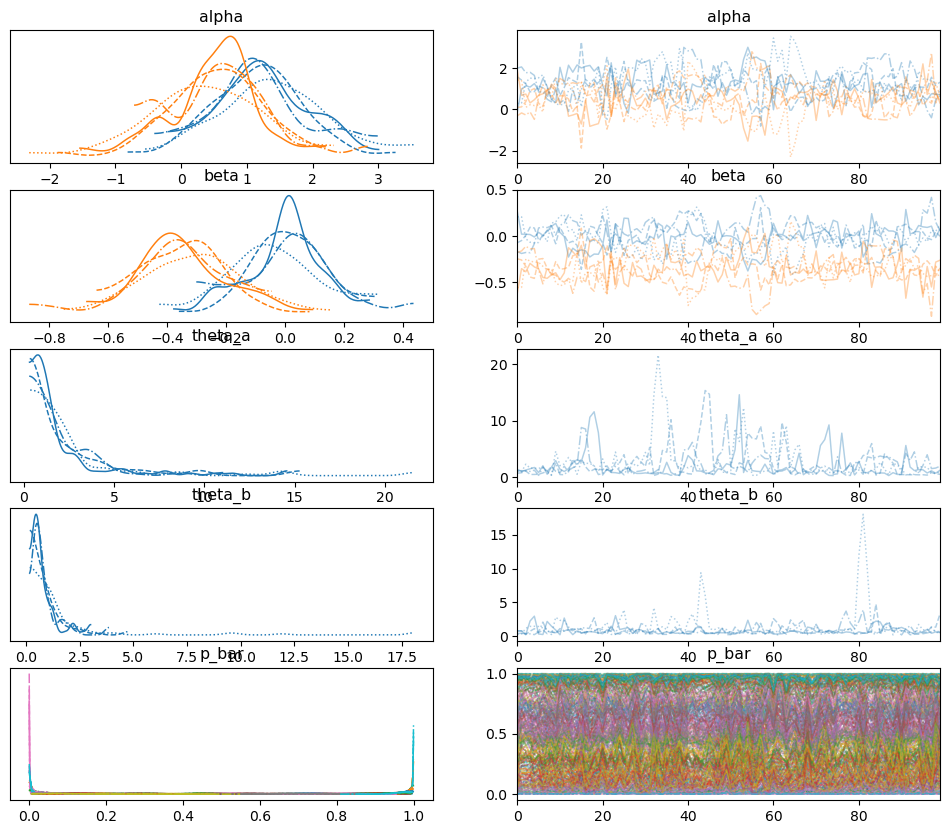

In [72]:
from src.teachers.BinomGLM import BinomGLM

# init binomial generalize linear model
mod = BinomGLM()

# fit
mod.fit(price, X, y, draws=100)

# print summary
sum = mod.summary()
print(sum.head())

# Posterior analysis
mod.plot_trace()
plt.show()

In [85]:
mod.alpha.shape

(400, 2)

### Get Posteriors 

For each user with covariates x, get a purchase probability posteriors for a price.

- We can see heterogneity in the demand curves for customers at a given price. some are more willing to buy than others.

(100, 400)


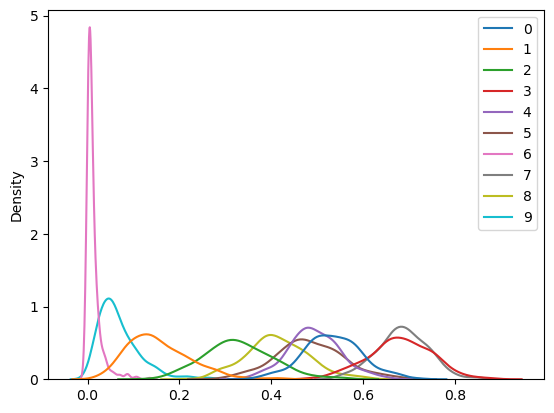

In [89]:
# get predictions
r = mod.predict_proba(price=5, X=X)

# save model as JSON
mod.save_params(f'../data/model=binomglm&dataset={dataset}&n_samples={n_samples}')

# all data points get a posterior 
# probability of purchase
print(r.shape)

# plot ten customers posteriors
sns.kdeplot(r[:10, :].T)
plt.show()

### Visualize Demand Curve

 - Overall demand on average decreases.

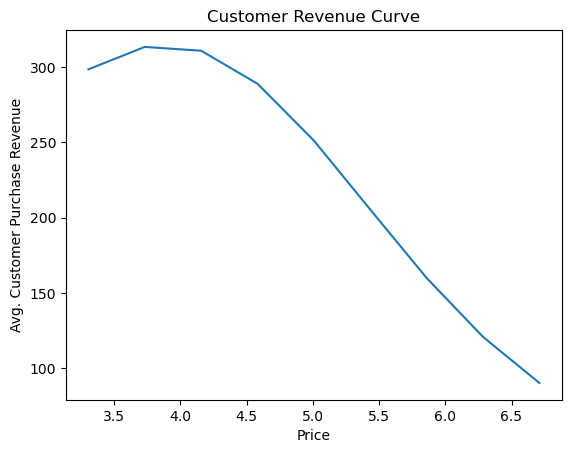

In [82]:
# get prices
prices = np.linspace(
    price.quantile(0.05), 
    price.quantile(0.95), 
    9
)

# get average purchase probability
avg_probas = [
    (mod.predict_proba(price, X=X).mean(axis=1) * price).sum()
    for price in prices
]

plt.plot(prices, avg_probas)

plt.title('Customer Revenue Curve')
plt.ylabel('Avg. Customer Purchase Revenue')
plt.xlabel('Price')

plt.show()

## Bayesian Additive Regression Trees